# Prejudice removal

**Uses the Prejudice removal in-processing algorithm from the AIF360 toolkit. Adds a discrimination-aware regularization term to the learning objective** 

See https://aif360.readthedocs.io/en/latest/modules/generated/aif360.algorithms.inprocessing.PrejudiceRemover.html <br />
See http://aif360.mybluemix.net/resources#guidance for guidance on metrics and mitigation algorithms

In [1]:
%matplotlib inline
import os
import sys
sys.path.insert(0, os.path.abspath('../src'))
import numpy as np
from tqdm import tqdm
from warnings import warn
import pandas as pd

from IPython.display import Markdown, display
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from common_utils import compute_metrics
from aif360.algorithms.inprocessing import PrejudiceRemover

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

# Import employment dataset 
from EmploymentDataset import EmploymentDataset
from util import preprocess_employment

/home/khuf/Projects/INFO381/.venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/khuf/Projects/INFO381/.venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/khuf/Projects/INFO381/.venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/khuf/Projects/INFO381/.venv/lib/python3.6/s

Matplotlib Error, comment out matplotlib.use('TkAgg')


/home/khuf/Projects/INFO381/.venv/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/khuf/Projects/INFO381/.venv/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/khuf/Projects/INFO381/.venv/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/khuf/Projects/INFO381/

In [2]:
privileged_groups = [{'Sex': 1}]
unprivileged_groups = [{'Sex': 0}]

# Fairness penalty paramenters
#eta = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 15.0, 20.0, 30.0, 40.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0] 

prejudice_remover = PrejudiceRemover(eta=10, sensitive_attr = 'Sex', class_attr='EmploymentStatus')
prejudice_no_penalty = PrejudiceRemover(eta= 0, sensitive_attr = 'Sex', class_attr='EmploymentStatus')
 
# Import the dataset
dataset_orig = preprocess_employment()

# Split dataset 70/30
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

In [3]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Original training dataset

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.093751
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.099402


In [4]:
standard_scaler = StandardScaler()
dataset_orig_train.features = standard_scaler.fit_transform(dataset_orig_train.features)
dataset_orig_test.features = standard_scaler.transform(dataset_orig_test.features)
metric_scaled_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Scaled dataset - Verify that the scaling does not affect the group label statistics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_train.mean_difference())
metric_scaled_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_test.mean_difference())

#### Scaled dataset - Verify that the scaling does not affect the group label statistics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.093751
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.099402


In [5]:
# Train the model
prejudice_no_penalty.fit(dataset_orig_train)

In [6]:
# Apply the unconstrained model to test data
dataset_train_transformed_plain = prejudice_no_penalty.predict(dataset_orig_train)
dataset_test_transformed_plain = prejudice_no_penalty.predict(dataset_orig_test)

In [7]:
# Metrics for the dataset from model without debiasing
display(Markdown("## No fairness contraints - dataset metrics"))
display(Markdown("#### Model without debiasing - dataset metrics"))
metric_dataset_prejudiceremover_train = BinaryLabelDatasetMetric(dataset_train_transformed_plain, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_prejudiceremover_train.mean_difference())

metric_dataset_prejudiceremover_test = BinaryLabelDatasetMetric(dataset_test_transformed_plain, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_prejudiceremover_test.mean_difference())

display(Markdown("#### Model without debiasing - classification metrics"))
classified_metric_prejudiceremover_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_test_transformed_plain,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_prejudiceremover_test.accuracy())
TPR = classified_metric_prejudiceremover_test.true_positive_rate()
TNR = classified_metric_prejudiceremover_test.true_negative_rate()
bal_acc_predjudiceremover_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_predjudiceremover_test)
print("Test set: Disparate impact = %f" % classified_metric_prejudiceremover_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_prejudiceremover_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_prejudiceremover_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_prejudiceremover_test.theil_index())

## No fairness contraints - dataset metrics

#### Model without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.059542
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.053113


#### Model without debiasing - classification metrics

Test set: Classification accuracy = 0.864627
Test set: Balanced classification accuracy = 0.769097
Test set: Disparate impact = 0.937622
Test set: Equal opportunity difference = -0.033432
Test set: Average odds difference = 0.038582
Test set: Theil_index = 0.066088


In [8]:
prejudice_remover.fit(dataset_orig_train)

In [9]:
# Apply the prejudice remover model to test data
dataset_train_transformed = prejudice_remover.predict(dataset_orig_train)
dataset_test_transformed = prejudice_remover.predict(dataset_orig_test)

In [10]:
display(Markdown("## No fairness contraints - dataset metrics"))
# Metrics for the dataset from model without debiasing
display(Markdown("#### Model without debiasing - dataset metrics"))
metric_dataset_prejudiceremover_train = BinaryLabelDatasetMetric(dataset_train_transformed_plain, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_prejudiceremover_train.mean_difference())

metric_dataset_prejudiceremover_test = BinaryLabelDatasetMetric(dataset_test_transformed_plain, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_prejudiceremover_test.mean_difference())

display(Markdown("#### Model without debiasing - classification metrics (test set)"))
classified_metric_prejudiceremover_test_plain = ClassificationMetric(dataset_orig_test, 
                                                 dataset_test_transformed_plain,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_prejudiceremover_test_plain.accuracy())
TPR = classified_metric_prejudiceremover_test_plain.true_positive_rate()
TNR = classified_metric_prejudiceremover_test_plain.true_negative_rate()
bal_acc_predjudiceremover_test = 0.5*(TPR+TNR)
unconstrainedFDR = classified_metric_prejudiceremover_test_plain.false_discovery_rate()
print("Test set: Balanced classification accuracy = %f" % bal_acc_predjudiceremover_test)
print("Test set: Disparate impact = %f" % classified_metric_prejudiceremover_test_plain.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_prejudiceremover_test_plain.equal_opportunity_difference())
print("Test set: Statistical parity difference = %f" % classified_metric_prejudiceremover_test_plain.mean_difference())
print("Test set: Average odds difference = %f" % classified_metric_prejudiceremover_test_plain.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_prejudiceremover_test_plain.theil_index())

###### Debiasing begins here ############


display(Markdown("## With fairness constraints - dataset metrics"))

# Metrics for the dataset from model with debiasing
display(Markdown("#### Model with debiasing - dataset metrics"))
metric_dataset_prejudiceremover_train = BinaryLabelDatasetMetric(dataset_train_transformed, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_prejudiceremover_train.mean_difference())

metric_dataset_prejudiceremover_test = BinaryLabelDatasetMetric(dataset_test_transformed, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_prejudiceremover_test.mean_difference())

display(Markdown("#### Model with biasing - classification metrics (test set)"))
classified_metric_prejudiceremover_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_test_transformed,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_prejudiceremover_test.accuracy())
TPR = classified_metric_prejudiceremover_test.true_positive_rate()
TNR = classified_metric_prejudiceremover_test.true_negative_rate()
bal_acc_predjudiceremover_test = 0.5*(TPR+TNR)
print("Balanced classification accuracy = %f" % bal_acc_predjudiceremover_test)
print("Test set: Disparate impact = %f" % classified_metric_prejudiceremover_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_prejudiceremover_test.equal_opportunity_difference())
print("Test set: Statistical parity difference = %f" % classified_metric_prejudiceremover_test.mean_difference())
print("Test set: Average odds difference = %f" % classified_metric_prejudiceremover_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_prejudiceremover_test.theil_index())


## No fairness contraints - dataset metrics

#### Model without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.059542
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.053113


#### Model without debiasing - classification metrics (test set)

Test set: Classification accuracy = 0.864627
Test set: Balanced classification accuracy = 0.769097
Test set: Disparate impact = 0.937622
Test set: Equal opportunity difference = -0.033432
Test set: Statistical parity difference = -0.053113
Test set: Average odds difference = 0.038582
Test set: Theil_index = 0.066088


## With fairness constraints - dataset metrics

#### Model with debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.019821
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.021610


#### Model with biasing - classification metrics (test set)

Test set: Classification accuracy = 0.851735
Balanced classification accuracy = 0.732238
Test set: Disparate impact = 0.974969
Test set: Equal opportunity difference = -0.017423
Test set: Statistical parity difference = -0.021610
Test set: Average odds difference = 0.072677
Test set: Theil_index = 0.062729


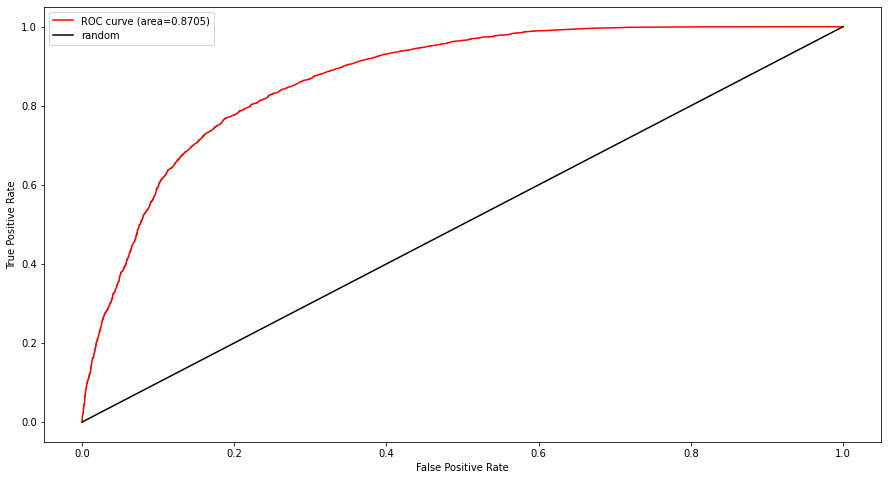

In [11]:

fpr_RF, tpr_RF, thresholds_RF = roc_curve(dataset_orig_test.labels, dataset_test_transformed.scores, pos_label=1)

plt.figure(figsize=(15,8))
ac = plt.plot(fpr_RF, tpr_RF,'r-',label = f'ROC curve (area={round(roc_auc_score(dataset_orig_test.labels, dataset_test_transformed.scores), 4)})')
plt.plot([0,1],[0,1],'k-',label='random')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.savefig("roc_curve_reject_option.svg")
plt.show()

ac

In [ ]:
display(Markdown("#### Running the algorithm for different eta values"))

accuracies, false_discovery_rates, statistical_rates, average_odds, disparate_impact, equal_opportunity, theil_index = [], [],\
[], [], [], [], []
sensitive_attribute = "Race"

eta = [1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 15.0, 20.0, 30.0, 40.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0] 

all_eta = np.linspace(0.0, 30, 30)
for e in range(31):
    print("eta: %.2f" % e)
    debiased_model = PrejudiceRemover(eta=e, sensitive_attr=sensitive_attribute)
    debiased_model.fit(dataset_orig_train)
    
    dataset_debiasing_test = debiased_model.predict(dataset_orig_test)
    predictions = dataset_debiasing_test.labels
    predictions = [1 if y == dataset_orig_train.favorable_label else -1 for y in predictions]
    
    classified_metric_prejudiceremover_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_debiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    acc = 0.5*(classified_metric_prejudiceremover_test.true_positive_rate()+classified_metric_prejudiceremover_test.true_negative_rate())
    sp =  classified_metric_prejudiceremover_test.mean_difference()
    fr = classified_metric_prejudiceremover_test.false_discovery_rate()
    eo = classified_metric_prejudiceremover_test.equal_opportunity_difference()
    ao = classified_metric_prejudiceremover_test.average_odds_difference()
    di = classified_metric_prejudiceremover_test.disparate_impact()
    ti = classified_metric_prejudiceremover_test.theil_index()
    print("accuracy: %.2f" % acc)
    print("fdr: %.2f" % fr)
    print("statistical parity: %.2f" % sp)
    
    ## Testing
    assert (fr >= unconstrainedFDR)
    
    accuracies.append(acc)
    false_discovery_rates.append(fr)
    statistical_rates.append(sp)
    equal_opportunity.append(eo)
    average_odds.append(ao)
    disparate_impact.append(di)
    theil_index.append(ti)
    

#### Running the algorithm for different eta values

eta: 0.00


In [ ]:
all_eta = np.linspace(0, 30, 31)
#metrics = [false_discovery_rates, statistical_rates, average_odds, disparate_impact, equal_opportunity]
metrics = {'statistical parity': ('x', statistical_rates, 'g'), 'average odds difference': ('o', average_odds, 'y'),\
           'equal opportunity': ('s', equal_opportunity, "b" )}

# 'false discovery rates': ('o', false_discovery_rates),
# 'disparate impact': ('+', disparate_impact),
display(Markdown("### Plot of accuracy and output fairness vs input constraint (eta)"))

display(Markdown("#### The graph illustrates the affect on fairness metrics for various values of eta"))

fig, ax1 = plt.subplots(figsize=(15,8))
ax1.plot(all_eta, accuracies, color='r')
ax1.set_title('Accuracy and fairness metrics vs eta', fontsize=16, fontweight='bold')
ax1.set_xlabel('Input eta', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced accuracy', color='r', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

for i in [1, 5, 10, 15, 20, 25, 30]:

    label = "{:.3f}".format(accuracies[i])

    plt.annotate(label,
                 (i, accuracies[i],),
                 textcoords="offset points",
                 xytext=(0,-18),
                 ha='center')

ax2 = ax1.twinx()
ax2.plot(all_eta,  statistical_rates, color='g')
ax2.plot(all_eta,  equal_opportunity, color='b')
ax2.plot(all_eta,  average_odds, color='y')
i = 0
for metric in metrics:
    for m in metrics[metric][1]:
        if i in [1, 5, 10, 15, 20, 25, 30]:
            plt.plot(all_eta[i], m, marker=metrics[metric][0], color=metrics[metric][2], label=metric if i == 1 else "")
            if i == 0:
                if metric != 'average odds difference':
                    plt.text(all_eta[i] * (1 + 0.01), m * (1 + 0.3) , round(m, 3), fontsize=12)
                else:
                    plt.text(all_eta[i] * (1 + 0.01), m * (1 + 0.01) , round(m, 3), fontsize=12)
            else:
                plt.text(all_eta[i] * (1 + 0.01), m * (1 + 0.01) , round(m, 3), fontsize=12)
        i = i + 1
    i = 0
    #plt.plot(all_eta, metrics[metric][1], metrics[metric][0], label=metric)
ax2.set_ylabel('closer to 0 is better', color='b', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
#ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.1))



plt.legend(loc='center', bbox_to_anchor=(0.5,0.07), numpoints=1)
yabs_max = abs(max(ax2.get_ylim(), key=abs))
ax2.set_ylim(ymin=-yabs_max, ymax=yabs_max)
ax2.grid(True)

plt.savefig("fairness_metrics_all_lines.svg")

In [ ]:
fig, ax1 = plt.subplots(figsize=(15,8))
ax1.plot(all_eta, accuracies, color='r')
ax1.set_title('Accuracy and $\gamma_{fdr}$ vs eta', fontsize=16, fontweight='bold')
ax1.set_xlabel('Input eta', fontsize=16, fontweight='bold')
ax1.set_ylabel('Accuracy', color='r', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

for i in [1, 5, 10, 15, 20, 25, 29]:

    label = "{:.2f}".format(accuracies[i])

    plt.annotate(label, # this is the text
                 (i, accuracies[i],), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-18), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

ax2 = ax1.twinx()    
ax2.plot(all_eta,  false_discovery_rates, color='b')
for i in [1, 5, 10, 15, 20, 25, 29]:

    label = "{:.2f}".format(false_discovery_rates[i])

    plt.annotate(label, # this is the text
                 (i, false_discovery_rates[i],), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-18), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
ax2.set_ylabel('$\gamma_{fdr}$', color='b', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig("false_discovery_rates_with_accuracy.svg")

In [ ]:
for index, e in enumerate(eta):
    print(f'eta {e}\naccuracy {accuracies[index]}\nstatistical paritity\n{false_discovery_rates[index]}{statistical_rates[index]}\n\n')

In [ ]:
fpr, tpr, thresholds = roc_curve(dataset_orig_test.labels, dataset_test_transformed_plain.scores)
print(f'{fpr}\n{tpr}\n{thresholds}')

fpr_RF, tpr_RF, thresholds_RF = roc_curve(dataset_orig_test.labels, dataset_test_transformed_plain.scores, pos_label=1)

plt.figure(figsize=(15,8))
plt.plot(fpr_RF, tpr_RF,'r-',label = f'ROC curve (area={round(roc_auc_score(dataset_orig_test.labels, dataset_test_transformed_plain.scores), 4)})')
plt.plot([0,1],[0,1],'k-',label='random')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig("roc_curve_prejudice_remover.svg")
plt.show()
### ROC END